<h1 style="font-size: 50px">Real-World Graphs</h1>

# imports, settings and needed functions

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.metrics import pairwise_distances
from scipy.sparse.linalg import eigsh 

In [2]:
np.random.seed(9)
font = {'size'   : 16}

plt.rc('font', **font)

General Functions

In [3]:
def knn_adjacency_matrix(features, k, metric='euclidean'):
    if k <= 0:
        raise ValueError("k must be a positive integer.")

    # Compute the pairwise distances
    distances = pairwise_distances(features, metric=metric)

    # Get the indices of the k-nearest neighbors for each point
    knn_indices = np.argsort(distances, axis=1)[:, 1:k+1]

    # Initialize the adjacency matrix
    n_points = features.shape[0]
    adjacency_matrix = np.zeros((n_points, n_points), dtype=float)

    # Fill the adjacency matrix
    for i in range(n_points):
        for j in knn_indices[i]:
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1  # Ensure the graph is undirected

    return adjacency_matrix
def get_thresholded_correlation_matrix(features, threshold):
    correlation_matrix = np.corrcoef(features)

    # Create a graph using the correlation matrix
    correlation_matrix[correlation_matrix < threshold] = 0
    return correlation_matrix
                

def get_normalised_laplacian(A):
    degrees = np.sum(A, axis=1)
    D_inv_sqrt = np.diag([1/np.sqrt(d) for d in degrees])
    return np.eye(len(A)) - D_inv_sqrt @ A @ D_inv_sqrt


def k_means_indicator_vectors(eigenvectors, K):
    assert eigenvectors.shape[1] >= K, 'Number of eigenvectors should be greater than or equal to K'
    kmeans = KMeans(n_clusters=K, random_state=0).fit(eigenvectors)
    indicator_vectors = np.zeros((eigenvectors.shape[0], K))
    for i in range(K):
        indicator_vectors[:,i] = kmeans.labels_ == i
    return indicator_vectors

def gram_schmidt(vectors):
    K = vectors.shape[1]
    vecs = vectors.copy()
    for i in range(K):
        vecs[:, i] = vecs[:, i] / np.linalg.norm(vecs[:, i])
        for j in range(i):
            vecs[:, i] = vecs[:, i] - (vecs[:, j].T @ vecs[:,i]) * vecs[:, j]
        vecs[:, i] = vecs[:, i] / np.linalg.norm(vecs[:, i])
    return vecs

def degree_correction(vectors, D_sqrt):
    vectors_corrected = vectors.copy()
    for i in range(vectors.shape[1]):
        vectors_corrected[:,i] = D_sqrt @ vectors[:,i]
        vectors_corrected[:,i] = vectors_corrected[:,i] / np.linalg.norm(vectors_corrected[:,i])
    return vectors_corrected

def compute_rayleigh_quotients(normalised_L, indicator_vectors, K):
    rayleigh_quotients = []
    assert indicator_vectors.shape[1] == K, 'Indicator vectors should have K columns'
    for i in range(K):
        indicator = indicator_vectors[:, i]
        val = (indicator.T @ normalised_L @ indicator) / (indicator.T @ indicator)
        rayleigh_quotients.append(val)
    return rayleigh_quotients


def dfs(node, adj_matrix, visited, component):
    """
    Depth-first search to collect all nodes in the same connected component.

    Parameters:
        node (int): The current node being visited.
        adj_matrix (numpy.ndarray): The adjacency matrix of the graph.
        visited (set): A set of visited nodes.
        component (list): List to store nodes in the current component.
    """
    visited.add(node)
    component.append(node)
    for neighbor, is_connected in enumerate(adj_matrix[node]):
        if is_connected and neighbor not in visited:
            dfs(neighbor, adj_matrix, visited, component)

def largest_connected_component(adj_matrix):
    """
    Finds the largest connected component of a graph from its adjacency matrix.

    Parameters:
        adj_matrix (numpy.ndarray): The adjacency matrix of the graph.

    Returns:
        numpy.ndarray: The adjacency matrix of the largest connected component.
        list: indices of nodes in largest component.
    """
    n = len(adj_matrix)
    visited = set()
    components = []

    # Find all connected components
    for node in range(n):
        if node not in visited:
            component = []
            dfs(node, adj_matrix, visited, component)
            components.append(component)

    # Identify the largest connected component
    largest_cc = max(components, key=len)

    # Create the adjacency matrix for the largest connected component
    size = len(largest_cc)
    largest_cc_matrix = np.zeros((size, size), dtype=int)

    node_index = {node: i for i, node in enumerate(largest_cc)}
    for i in largest_cc:
        for j in largest_cc:
            if adj_matrix[i][j]:
                largest_cc_matrix[node_index[i]][node_index[j]] = 1

    return largest_cc_matrix, largest_cc


Simple search algorithm for finding a good split of eigenvalues to apply the recursive structure theorem

In [4]:
def apply_recursive_st(rayleigh_quotients, eigenvalues, start, end, error):
    R = rayleigh_quotients[start:end]
    l = end-start
    val = np.sum(R) - l * eigenvalues[start] + eigenvalues[end] * error
    if (eigenvalues[end] != eigenvalues[start]) and (eigenvalues[end] != 0):
        val = val / (eigenvalues[end] - eigenvalues[start])
        return val
    else:
        return 0

# for this version we have to specify the indices where we want to compute the recursive st on. so if we passed in [0,1,K] this would achieve the bounds from corollary 5. You must start from 0 and end with K. It will consider from 0 to K-1 (the first K terms)  in the sum. 
def apply_recursive_st_given_indices(rayleigh_quotients, eigenvalues, indices):
    values = []
    for i, i_add_1 in zip(indices, indices[1:]):
        error = np.sum(values)
        val = apply_recursive_st(rayleigh_quotients, eigenvalues, i, i_add_1, error)
        values.append(val)
    return values


A function for generating increasing list from 0 to K.

In [5]:
def generate_increasing_lists(K):
    """
    Generate all lists of increasing integers from 0 to K.

    Parameters:
    K (int): A positive integer.

    Returns:
    list: A list of lists containing increasing sequences from 0 to K.
    """
    if K < 0:
        raise ValueError("K must be a positive integer")

    # Create the range of numbers from 0 to K
    numbers = list(range(K + 1))

    # Generate all combinations of indices (at least 2 elements: 0 and K are mandatory)
    result = []
    for r in range(2, len(numbers) + 1):
        for combination in combinations(numbers[1:-1], r - 2):
            result.append([0] + list(combination) + [K])

    return result

In [6]:
def apply_recursive_st_brute_force(rayleigh_quotients, eigenvalues, K):
    list_of_indice_splits = generate_increasing_lists(K)
    min_split = np.inf
    min_split_indices = list_of_indice_splits[0]
    for indices_split in list_of_indice_splits:
        val = np.sum(apply_recursive_st_given_indices(rayleigh_quotients, eigenvalues, indices_split))
        if val < min_split:
            min_split = val
            min_split_indices = indices_split
    return min_split_indices, min_split

In [7]:
dataset_results = {}

# MNIST Dataset

In [8]:
# Load the MNIST dataset using OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
x_data, y_data = mnist.data, mnist.target.astype(int)

# Select 3 digits (e.g., 0, 1, and 2) and restrict to 200 samples each
digits = [0, 1, 2, 3, 4]
samples_per_digit = 500
selected_samples = []
selected_labels = []

# taking a sample of each digit
for digit in digits:
    indices = np.where(y_data == digit)[0][:samples_per_digit]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

# Combine the samples into a single dataset
selected_samples = np.vstack(selected_samples) / 255.0  # Normalize pixel values
selected_labels = np.array(selected_labels)

# Create a graph using the correlation matrix
threshold = 0.7  # Define a threshold for edge creation
adjacency_matrix = get_thresholded_correlation_matrix(selected_samples, threshold)
adjacency_matrix_largest_cc, largest_cc = largest_connected_component(adjacency_matrix) 
normalized_laplacian = get_normalised_laplacian(adjacency_matrix_largest_cc)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [9]:
# compute first K eigenvectors of the normalized Laplacian
K=5
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix_largest_cc, axis = 0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                    combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                         i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


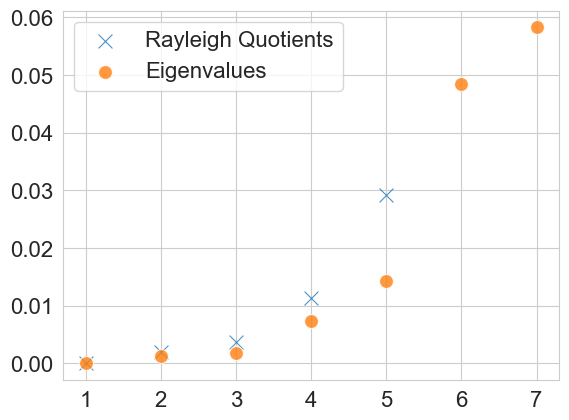

In [10]:
# plot of eigenvalues and rayleigh quotients
sns.scatterplot(x = [1,2,3,4,5],y = rayleigh_quotients, alpha = 0.8, marker='x', s=100, label='Rayleigh Quotients')
sns.scatterplot(x = [1,2,3,4,5,6,7], y = normalized_L_eigenvalues[0:7], alpha = 0.8, marker = 'o',s=100, label='Eigenvalues')
plt.legend()

In [11]:
true_val_matrix_combined = normalized_L_eigenvectors[:,:K] - indicator_vectors @ (indicator_vectors.T @ normalized_L_eigenvectors[:,:K])
true_val_combined = (1/K) * np.linalg.norm(true_val_matrix_combined)

In [12]:
split, v = apply_recursive_st_brute_force(rayleigh_quotients, normalized_L_eigenvalues[0:6], K)

In [13]:
mnist_dataset_results = {}
print("K: ", K)
mnist_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix_largest_cc))
mnist_dataset_results["N"] = len(adjacency_matrix_largest_cc)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0))
mnist_dataset_results["M"] = np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0)
print("True value: ", true_val_combined)
mnist_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
mnist_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
mnist_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", v/5)
mnist_dataset_results["Recursive ST"] = v/5

dataset_results["MNIST"] = mnist_dataset_results

K:  5
Number of vertices N:  2348
Number of edges M:  140018
True value:  0.050540752722538024
M&S ST:  0.43945091443546835
General ST:  0.1914964218584773
Recursive ST:  0.17442659367391106


# Fashion MNIST

In [14]:
# Load the MNIST dataset using OpenML
mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
x_data, y_data = mnist.data, mnist.target.astype(int)

# Select 3 digits (e.g., 0, 1, and 2) and restrict to 200 samples each
digits = [0, 1, 2]
samples_per_digit = 1000
selected_samples = []
selected_labels = []

# taking a sample of each digit
for digit in digits:
    indices = np.where(y_data == digit)[0][:samples_per_digit]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

# Combine the samples into a single dataset
selected_samples = np.vstack(selected_samples) / 255.0  # Normalize pixel values
selected_labels = np.array(selected_labels)

# Create a graph using the correlation matrix
threshold = 0.7  # Define a threshold for edge creation
adjacency_matrix = get_thresholded_correlation_matrix(selected_samples, threshold)
adjacency_matrix_largest_cc, largest_cc = largest_connected_component(adjacency_matrix) 


C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [15]:
vertices_to_remove = [318,319,320]
adjacency_matrix_largest_cc = np.delete(adjacency_matrix_largest_cc, vertices_to_remove, axis=0)
adjacency_matrix_largest_cc = np.delete(adjacency_matrix_largest_cc, vertices_to_remove, axis=1)
normalized_laplacian = get_normalised_laplacian(adjacency_matrix_largest_cc)

<Axes: >

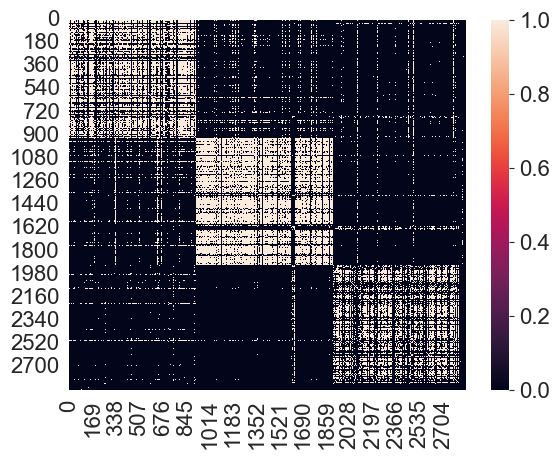

In [16]:
sns.heatmap(adjacency_matrix_largest_cc)

In [17]:
# compute first K eigenvectors of the normalized Laplacian
K=6
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix_largest_cc, axis = 0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                    combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                         i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


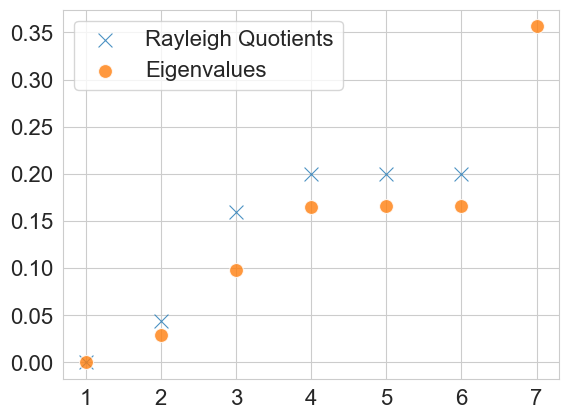

In [18]:
# plot of eigenvalues and rayleigh quotients
sns.scatterplot(x=[1, 2, 3, 4, 5, 6], y=rayleigh_quotients, alpha=0.8, marker='x', s=100, label='Rayleigh Quotients')
sns.scatterplot(x=[1, 2, 3, 4, 5, 6, 7], y=normalized_L_eigenvalues[0:7], alpha=0.8, marker='o', s=100, label='Eigenvalues')
plt.legend()

In [19]:
split, v = apply_recursive_st_brute_force(rayleigh_quotients, normalized_L_eigenvalues[0:7], K)

In [20]:
true_val_matrix_combined = normalized_L_eigenvectors[:, :K] - indicator_vectors @ (
            indicator_vectors.T @ normalized_L_eigenvectors[:, :K])
true_val_combined = (1 / K) * np.linalg.norm(true_val_matrix_combined)

fashion_mnist_dataset_results = {}
print("K: ", K)
fashion_mnist_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix_largest_cc))
fashion_mnist_dataset_results["N"] = len(adjacency_matrix_largest_cc)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0))
fashion_mnist_dataset_results["M"] = np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0)
print("True value: ", true_val_combined)
fashion_mnist_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
fashion_mnist_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
fashion_mnist_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", np.sum(v)/K)
fashion_mnist_dataset_results["Recursive ST"] = np.sum(v)/K

dataset_results["Fashion MNIST"] = fashion_mnist_dataset_results

K:  6
Number of vertices N:  2872
Number of edges M:  1711206
True value:  0.07599798898093614
M&S ST:  0.5613847171007009
General ST:  0.3760754278388082
Recursive ST:  0.3224784094472107


# Wine Dataset

In [21]:
wine_df = pd.read_csv("Data/Wine dataset.csv")

In [22]:
wine_df_targets = wine_df['class']
wine_df_features = wine_df.drop(columns = ['class'])
wine_df_features_normalized = (wine_df_features - wine_df_features.mean())/wine_df_features.std()
wine_df_features_normalized.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1.514341,-0.560668,0.231400,-1.166303,1.908522,0.806722,1.031908,-0.657708,1.221438,0.251009,0.361158,1.842721,1.010159
1,0.245597,-0.498009,-0.825667,-2.483841,0.018094,0.567048,0.731565,-0.818411,-0.543189,-0.292496,0.404908,1.110317,0.962526
2,0.196325,0.021172,1.106214,-0.267982,0.088110,0.806722,1.212114,-0.497005,2.129959,0.268263,0.317409,0.786369,1.391224
3,1.686791,-0.345835,0.486554,-0.806975,0.928300,2.484437,1.462399,-0.979113,1.029251,1.182732,-0.426341,1.180741,2.328007
4,0.294868,0.227053,1.835226,0.450674,1.278379,0.806722,0.661485,0.226158,0.400275,-0.318377,0.361158,0.448336,-0.037767


In [23]:
wine_df_features_cov = np.cov(wine_df_features_normalized)
wine_df_features_cov_thresholded = wine_df_features_cov.copy()
wine_df_features_cov_thresholded[wine_df_features_cov_thresholded < 0.3] = 0
wine_df_features_cov_thresholded[wine_df_features_cov_thresholded >= 0.3] = 1 
adjacency_matrix = wine_df_features_cov_thresholded.copy()

normalized_laplacian = get_normalised_laplacian(adjacency_matrix)

# compute first K eigenvectors of the normalized Laplacian
K = 3
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix, axis=0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                     i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


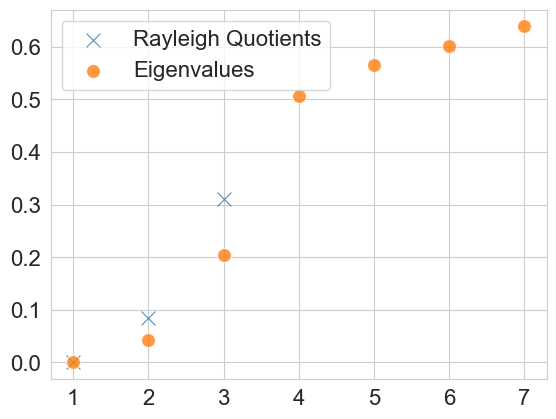

In [24]:
# plot of eigenvalues and rayleigh quotients
sns.scatterplot(x=range(1,K+1), y=rayleigh_quotients, alpha=0.8, marker='x', s=100, label='Rayleigh Quotients')
sns.scatterplot(x=range(1,8), y=normalized_L_eigenvalues[0:7], alpha=0.8, marker='o', s=100, label='Eigenvalues')
plt.legend()

In [25]:
true_val_matrix_combined = normalized_L_eigenvectors[:, :K] - indicator_vectors @ (
        indicator_vectors.T @ normalized_L_eigenvectors[:, :K])
true_val_combined = (1 / K) * np.linalg.norm(true_val_matrix_combined) ** 2

rayleigh_quotients = np.round(rayleigh_quotients, 6)
normalized_L_eigenvalues = np.round(normalized_L_eigenvalues, 6)

#b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])
split, v = apply_recursive_st_brute_force(rayleigh_quotients, normalized_L_eigenvalues[0:K+1], K)


wine_dataset_results = {}
print("K: ", K)
wine_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix))
wine_dataset_results["N"] = len(adjacency_matrix)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix, axis=1), axis=0))
wine_dataset_results["M"] = np.sum(np.sum(adjacency_matrix, axis=1), axis=0)
print("True value: ", true_val_combined)
wine_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
wine_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
wine_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", v/K)
wine_dataset_results["Recursive ST"] = v/K

dataset_results["Wine"] = wine_dataset_results

K:  3
Number of vertices N:  178
Number of edges M:  6890.0
True value:  0.06456321090483377
M&S ST:  0.4498140716518029
General ST:  0.2608675038669646
Recursive ST:  0.2241476126260037


## Air Quality Dataset
https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment

In [26]:
pollution_df = pd.read_csv("Data/updated_pollution_dataset.csv")
pollution_df = pollution_df.sort_values(by='Air Quality').reset_index(drop=True)

# Separate targets and features
pollution_df_targets = pollution_df['Air Quality']
pollution_df_features = pollution_df.drop(columns=['Air Quality'])

# Normalize features
pollution_df_features_normalized = (pollution_df_features - pollution_df_features.mean()) / pollution_df_features.std()

# Calculate covariance matrix
pollution_df_features_cov = np.cov(pollution_df_features_normalized)

# Threshold covariance matrix
pollution_df_features_cov_thresholded = pollution_df_features_cov.copy()
pollution_df_features_cov_thresholded[pollution_df_features_cov_thresholded < 0.4] = 0
pollution_df_features_cov_thresholded[pollution_df_features_cov_thresholded >= 0.4] = 1

In [27]:
# Remove zero rows and columns
non_zero_indices = np.where(~(pollution_df_features_cov_thresholded == 0).all(axis=1))[0]
pollution_df_features_cov_thresholded = pollution_df_features_cov_thresholded[non_zero_indices][:, non_zero_indices]

# Adjacency matrix
adjacency_matrix = pollution_df_features_cov_thresholded.copy()

<Axes: >

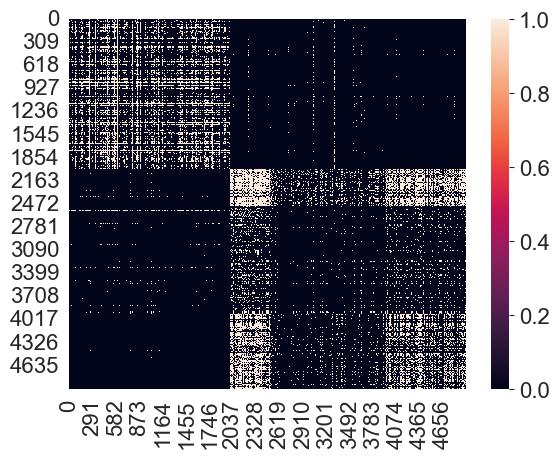

In [28]:
sns.heatmap(adjacency_matrix)

In [29]:
normalized_laplacian = get_normalised_laplacian(adjacency_matrix)

# compute first K eigenvectors of the normalized Laplacian
K = 3
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix, axis=0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                     i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

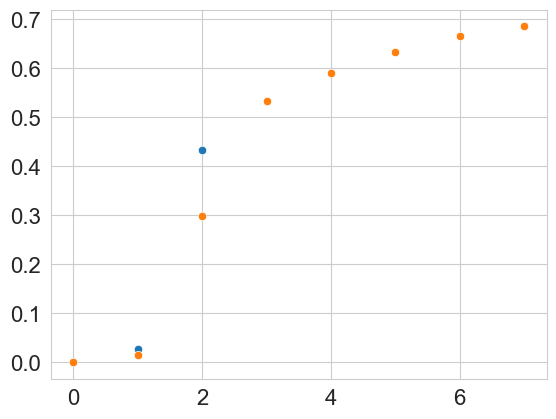

In [30]:
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(normalized_L_eigenvalues[:8])

In [31]:
true_val_matrix_combined = normalized_L_eigenvectors[:, :K] - indicator_vectors @ (
        indicator_vectors.T @ normalized_L_eigenvectors[:, :K])
true_val_combined = (1 / K) * np.linalg.norm(true_val_matrix_combined)

rayleigh_quotients = np.round(rayleigh_quotients, 6)
normalized_L_eigenvalues = np.round(normalized_L_eigenvalues, 6)

#b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])
split, v = apply_recursive_st_brute_force(rayleigh_quotients, normalized_L_eigenvalues[0:K+1], K)


air_quality_dataset_results = {}
print("K: ", K)
air_quality_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix))
air_quality_dataset_results["N"] = len(adjacency_matrix)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix, axis=1), axis=0))
air_quality_dataset_results["M"] = np.sum(np.sum(adjacency_matrix, axis=1), axis=0)
print("True value: ", true_val_combined)
air_quality_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
air_quality_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
air_quality_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", v/K)
air_quality_dataset_results["Recursive ST"] = v/K

dataset_results["Air Quality"] = air_quality_dataset_results

K:  3
Number of vertices N:  4942
Number of edges M:  2784780.0
True value:  0.14891491714898944
M&S ST:  0.623387989479016
General ST:  0.2883044898689639
Recursive ST:  0.23496231189301262


## Twitch 


Eigenvalues of the Laplacian:
[-3.21667402e-17  1.08241298e-01  1.33718984e-01  1.50752124e-01
  1.63661113e-01  1.67765911e-01  1.84350772e-01  1.87884480e-01
  1.89326959e-01  1.98710492e-01  2.03873360e-01  2.11466237e-01
  2.18909479e-01  2.45404022e-01  2.45524390e-01  2.74171858e-01
  2.76505637e-01  2.77181707e-01  2.78134133e-01  2.78162756e-01]


<Axes: >

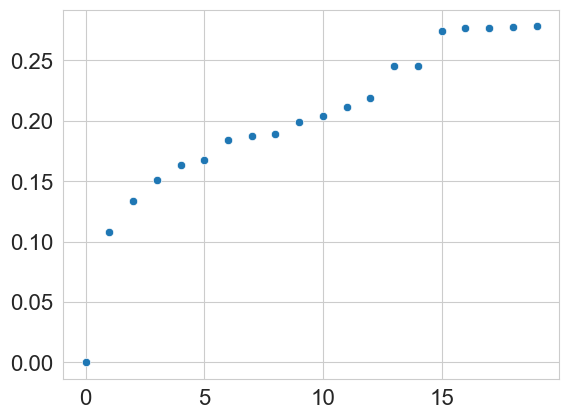

In [32]:
# Step 1: Define the file path
edge_list_path = "Data/twitch_gamers/large_twitch_edges.csv"
df = pd.read_csv(edge_list_path)
df.to_csv("Data/twitch_gamers/twitch_cleaned_edges.csv", index=False, header=False)
# Step 2: Load the Deezer graph
# Assuming the edge list is in CSV format with two columns: source and target
G = nx.read_edgelist("Data/twitch_gamers/twitch_cleaned_edges.csv", delimiter=",", nodetype=int, data=False)

laplacian_sparse = nx.normalized_laplacian_matrix(G).astype(np.float64)

degrees = dict(G.degree())
# Compute the square root of the degrees
inv_sqrt_degrees = np.array([1 / np.sqrt(degrees[node]) if degrees[node] != 0 else 0 for node in G.nodes()])

# Step 4: Compute the smallest 6 eigenvalues of the Laplacian (for example)
num_eigenvalues = 20
eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=num_eigenvalues, which="SM")

# Output results
print("\nEigenvalues of the Laplacian:")
print(eigenvalues)
sns.scatterplot(eigenvalues)

In [33]:
K = 2
# Perform K-means clustering on the eigenvectors
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
scaled_eigenvectors = inv_sqrt_degrees[:, np.newaxis] * eigenvectors

clusters = kmeans.fit_predict(scaled_eigenvectors[:, :K])

degrees = dict(G.degree())
# Compute the square root of the degrees
sqrt_degrees = np.array([np.sqrt(degrees[node]) for node in G.nodes()])

# Compute Rayleigh quotients for each cluster
rayleigh_quotients = []
indicator_vectors = np.zeros(eigenvectors.shape)

for cluster_idx in range(K):
    # Create indicator vector for the cluster
    indicator_vector = (clusters == cluster_idx).astype(float) * sqrt_degrees
    indicator_vector = indicator_vector / np.linalg.norm(indicator_vector, 2)
    indicator_vectors[:, cluster_idx] = indicator_vector
    # Compute Rayleigh quotient
    numerator = indicator_vector.T @ laplacian_sparse @ indicator_vector
    denominator = indicator_vector.T @ indicator_vector
    rayleigh_quotients.append(numerator / denominator)

rayleigh_quotients = sorted(rayleigh_quotients)
beta_K_by_K = indicator_vectors.T @ scaled_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
combined_indicator_vectors = gram_schmidt(combined_indicator_vectors)
combined_rayleigh_quotients = []
for i in range(K):
    numerator = combined_indicator_vectors[:, i].T @ laplacian_sparse @ combined_indicator_vectors[:, i]
    denominator = combined_indicator_vectors[:, i].T @ combined_indicator_vectors[:, i]
    combined_rayleigh_quotients.append(numerator / denominator)

combined_rayleigh_quotients = sorted(combined_rayleigh_quotients)

<Axes: >

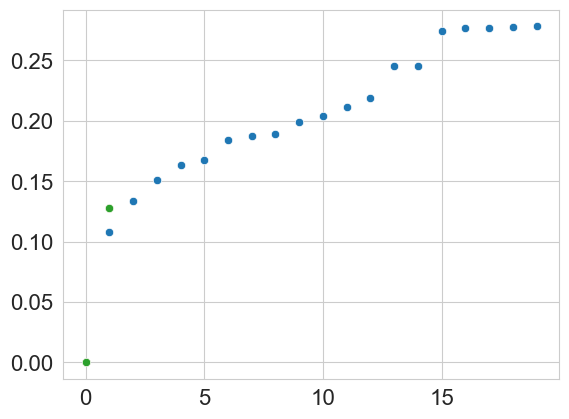

In [34]:

sns.scatterplot(eigenvalues)
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(combined_rayleigh_quotients)

In [35]:
true_val_matrix_combined = eigenvectors[:, :K] - indicator_vectors @ (
        indicator_vectors.T @ eigenvectors[:, :K])
true_val_combined = (1 / K) * np.linalg.norm(true_val_matrix_combined)

rayleigh_quotients = np.round(rayleigh_quotients, 6)
normalized_L_eigenvalues = np.round(eigenvalues, 6)

#b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])
split, v = apply_recursive_st_brute_force(rayleigh_quotients, eigenvalues[0:K+1], K)


twitch_dataset_results = {}
print("K: ", K)
twitch_dataset_results["K"] = K
print("Number of vertices N: ", len(eigenvectors))
twitch_dataset_results["N"] = len(eigenvectors)
print("Number of edges M: ", np.sum(list(degrees.values())) / 2)
twitch_dataset_results["M"] = np.sum(list(degrees.values())) / 2
print("True value: ", true_val_combined)
twitch_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors))/eigenvalues[K])
twitch_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors))/eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * eigenvalues[K]))
twitch_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * eigenvalues[K])
print("Recursive ST: ", v/K)
twitch_dataset_results["Recursive ST"] = v/K

dataset_results["Twitch"] = twitch_dataset_results

K:  2
Number of vertices N:  168114
Number of edges M:  6797557.0
True value:  0.07859663668724516
M&S ST:  0.956694349115806
General ST:  0.47929245416479177
Recursive ST:  0.3936543431607175


## Last Fm Asia


Eigenvalues of the Laplacian:
[7.79422883e-17 9.45114577e-03 1.55111573e-02 2.02928669e-02
 2.22573849e-02 2.55497997e-02 3.51437319e-02 3.85141178e-02
 3.93611728e-02 3.98308817e-02 4.03938250e-02 4.26164588e-02
 4.63386198e-02 5.27547809e-02 5.49798081e-02 5.59413678e-02
 5.63246225e-02 5.90606149e-02 6.47341502e-02 6.51394239e-02]


<Axes: >

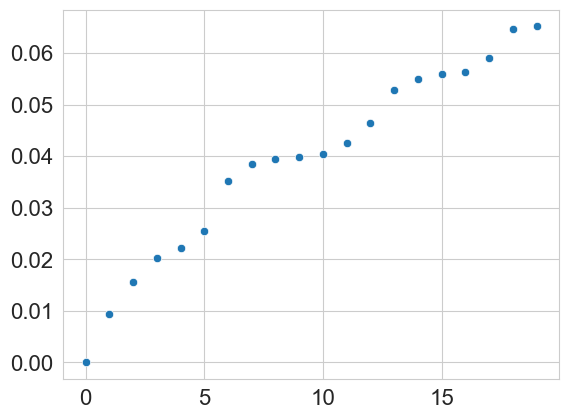

In [36]:
# Step 1: Define the file path
edge_list_path = "Data/lasftm_asia/lastfm_asia_edges.csv"
df = pd.read_csv(edge_list_path)
df.to_csv("Data/lasftm_asia/lastfm_asia_edges.csv", index=False, header=False)
# Step 2: Load the Deezer graph
# Assuming the edge list is in CSV format with two columns: source and target
G = nx.read_edgelist("Data/lasftm_asia/lastfm_asia_edges.csv", delimiter=",", nodetype=int, data=False)

laplacian_sparse = nx.normalized_laplacian_matrix(G).astype(np.float64)

degrees = dict(G.degree())
# Compute the square root of the degrees
inv_sqrt_degrees = np.array([1 / np.sqrt(degrees[node]) if degrees[node] != 0 else 0 for node in G.nodes()])

# Step 4: Compute the smallest 6 eigenvalues of the Laplacian (for example)
num_eigenvalues = 20
eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=num_eigenvalues, which="SM")

# Output results
print("\nEigenvalues of the Laplacian:")
print(eigenvalues)
sns.scatterplot(eigenvalues)

In [37]:
K = 2
# Perform K-means clustering on the eigenvectors
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
scaled_eigenvectors = inv_sqrt_degrees[:, np.newaxis] * eigenvectors

clusters = kmeans.fit_predict(scaled_eigenvectors[:, :K])

degrees = dict(G.degree())
# Compute the square root of the degrees
sqrt_degrees = np.array([np.sqrt(degrees[node]) for node in G.nodes()])

# Compute Rayleigh quotients for each cluster
rayleigh_quotients = []
indicator_vectors = np.zeros(eigenvectors.shape)

for cluster_idx in range(K):
    # Create indicator vector for the cluster
    indicator_vector = (clusters == cluster_idx).astype(float) * sqrt_degrees
    indicator_vector = indicator_vector / np.linalg.norm(indicator_vector, 2)
    indicator_vectors[:, cluster_idx] = indicator_vector
    # Compute Rayleigh quotient
    numerator = indicator_vector.T @ laplacian_sparse @ indicator_vector
    denominator = indicator_vector.T @ indicator_vector
    rayleigh_quotients.append(numerator / denominator)

rayleigh_quotients = sorted(rayleigh_quotients)
beta_K_by_K = indicator_vectors.T @ scaled_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
combined_indicator_vectors = gram_schmidt(combined_indicator_vectors)
combined_rayleigh_quotients = []
for i in range(K):
    numerator = combined_indicator_vectors[:, i].T @ laplacian_sparse @ combined_indicator_vectors[:, i]
    denominator = combined_indicator_vectors[:, i].T @ combined_indicator_vectors[:, i]
    combined_rayleigh_quotients.append(numerator / denominator)

combined_rayleigh_quotients = sorted(combined_rayleigh_quotients)

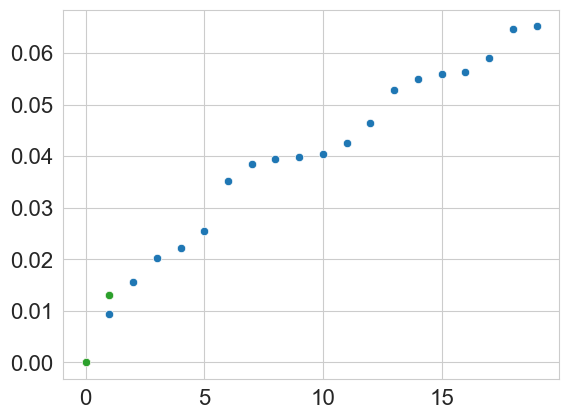

In [38]:

sns.scatterplot(eigenvalues)
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(combined_rayleigh_quotients)
v = apply_recursive_st_given_indices(combined_rayleigh_quotients, eigenvalues[0:K + 1], [0,1, K])

In [39]:
lastfm_dataset_results = {}
true_val_matrix_combined = eigenvectors[:, :K] - indicator_vectors @ (
        indicator_vectors.T @ eigenvectors[:, :K])
true_val_combined = (1 / K) * np.linalg.norm(true_val_matrix_combined)

rayleigh_quotients = np.round(rayleigh_quotients, 6)
normalized_L_eigenvalues = np.round(eigenvalues, 6)

#b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])
split, v = apply_recursive_st_brute_force(rayleigh_quotients, eigenvalues[0:K+1], K)


lastfm_dataset_results = {}
print("K: ", K)
lastfm_dataset_results["K"] = K
print("Number of vertices N: ", len(eigenvectors))
lastfm_dataset_results["N"] = len(eigenvectors)
print("Number of edges M: ", np.sum(list(degrees.values())) / 2)
lastfm_dataset_results["M"] = np.sum(list(degrees.values())) / 2
print("True value: ", true_val_combined)
lastfm_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors))/eigenvalues[K])
lastfm_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors))/eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * eigenvalues[K]))
lastfm_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * eigenvalues[K])
print("Recursive ST: ", v/K)
lastfm_dataset_results["Recursive ST"] = v/K

dataset_results["LastFM"] = lastfm_dataset_results

K:  2
Number of vertices N:  7622
Number of edges M:  27800.0
True value:  0.04851018228288054
M&S ST:  0.8372691190716656
General ST:  0.42214774075945843
Recursive ST:  0.3122629692437986


## Gemsec Facebook - Athletes


Eigenvalues of the Laplacian:
[-1.71460284e-17  1.40582489e-02  1.55717317e-02  3.68857668e-02
  4.72368038e-02  5.06513445e-02  5.80770220e-02  6.26098126e-02
  6.53869940e-02  6.75294643e-02  6.90622932e-02  7.40656899e-02
  7.98982102e-02  8.11412019e-02  8.17376535e-02  8.70868983e-02
  8.93566929e-02  8.99033076e-02  9.35597639e-02  9.60187612e-02]


<Axes: >

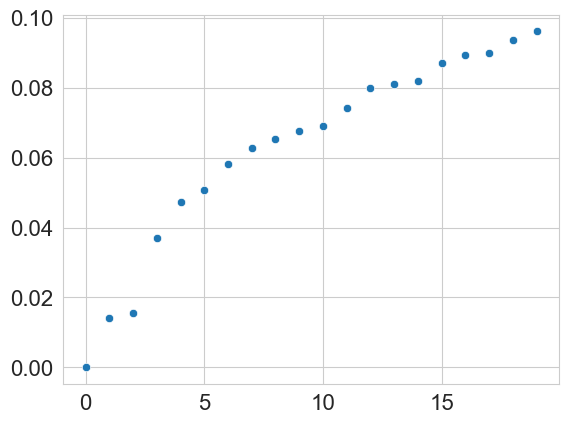

In [40]:
# Step 1: Define the file path
edge_list_path = "Data/facebook_clean_data/athletes_edges.csv"
df = pd.read_csv(edge_list_path)
df.to_csv("Data/facebook_clean_data/athletes_edges.csv", index=False, header=False)
# Step 2: Load the Deezer graph
# Assuming the edge list is in CSV format with two columns: source and target
G = nx.read_edgelist("Data/facebook_clean_data/athletes_edges.csv", delimiter=",", nodetype=int, data=False)

laplacian_sparse = nx.normalized_laplacian_matrix(G).astype(np.float64)

degrees = dict(G.degree())
# Compute the square root of the degrees
inv_sqrt_degrees = np.array([1 / np.sqrt(degrees[node]) if degrees[node] != 0 else 0 for node in G.nodes()])

# Step 4: Compute the smallest 6 eigenvalues of the Laplacian (for example)
num_eigenvalues = 20
eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=num_eigenvalues, which="SM")

# Output results
print("\nEigenvalues of the Laplacian:")
print(eigenvalues)
sns.scatterplot(eigenvalues)

In [41]:
K = 3
# Perform K-means clustering on the eigenvectors
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
scaled_eigenvectors = inv_sqrt_degrees[:, np.newaxis] * eigenvectors

clusters = kmeans.fit_predict(scaled_eigenvectors[:, :K])

degrees = dict(G.degree())
# Compute the square root of the degrees
sqrt_degrees = np.array([np.sqrt(degrees[node]) for node in G.nodes()])

# Compute Rayleigh quotients for each cluster
rayleigh_quotients = []
indicator_vectors = np.zeros(eigenvectors.shape)

for cluster_idx in range(K):
    # Create indicator vector for the cluster
    indicator_vector = (clusters == cluster_idx).astype(float) * sqrt_degrees
    indicator_vector = indicator_vector / np.linalg.norm(indicator_vector, 2)
    indicator_vectors[:, cluster_idx] = indicator_vector
    # Compute Rayleigh quotient
    numerator = indicator_vector.T @ laplacian_sparse @ indicator_vector
    denominator = indicator_vector.T @ indicator_vector
    rayleigh_quotients.append(numerator / denominator)

rayleigh_quotients = sorted(rayleigh_quotients)
beta_K_by_K = indicator_vectors.T @ scaled_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
combined_indicator_vectors = gram_schmidt(combined_indicator_vectors)

combined_rayleigh_quotients = []
for i in range(K):
    numerator = combined_indicator_vectors[:, i].T @ laplacian_sparse @ combined_indicator_vectors[:, i]
    denominator = combined_indicator_vectors[:, i].T @ combined_indicator_vectors[:, i]
    combined_rayleigh_quotients.append(numerator / denominator)

combined_rayleigh_quotients = sorted(combined_rayleigh_quotients)

<Axes: >

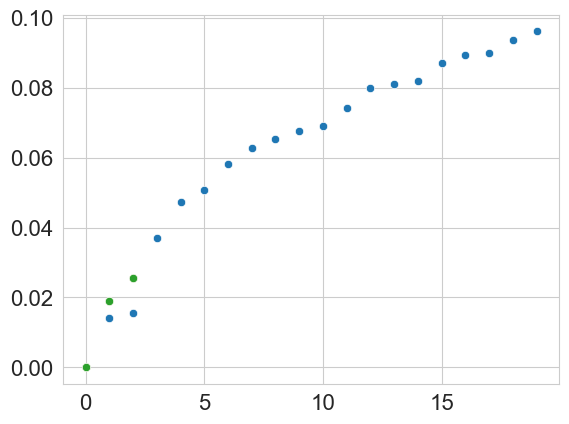

In [42]:

sns.scatterplot(eigenvalues)
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(combined_rayleigh_quotients)

In [43]:
facebook_athletes_dataset_results = {}
true_val_matrix_combined = eigenvectors[:, :K] - indicator_vectors @ (
        indicator_vectors.T @ eigenvectors[:, :K])
true_val_combined = (1 / K) * np.linalg.norm(true_val_matrix_combined)

rayleigh_quotients = np.round(rayleigh_quotients, 6)
normalized_L_eigenvalues = np.round(eigenvalues, 6)

#b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])
split, v = apply_recursive_st_brute_force(rayleigh_quotients, eigenvalues[0:K+1], K)


facebook_athletes_dataset_results = {}
print("K: ", K)
facebook_athletes_dataset_results["K"] = K
print("Number of vertices N: ", len(eigenvectors))
facebook_athletes_dataset_results["N"] = len(eigenvectors)
print("Number of edges M: ", np.sum(list(degrees.values())) / 2)
facebook_athletes_dataset_results["M"] = np.sum(list(degrees.values())) / 2
print("True value: ", true_val_combined)
facebook_athletes_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors))/eigenvalues[K])
facebook_athletes_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors))/eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * eigenvalues[K]))
facebook_athletes_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * eigenvalues[K])
print("Recursive ST: ", v/K)
facebook_athletes_dataset_results["Recursive ST"] = v/K

dataset_results["Facebook (Athletes)"] = facebook_athletes_dataset_results

K:  3
Number of vertices N:  13866
Number of edges M:  86852.0
True value:  0.042710138801476075
M&S ST:  0.6951468782835383
General ST:  0.403263045854819
Recursive ST:  0.2426591648937949


## Collaborations CA-CondMat

In [44]:

# Step 1: Define the file path
# Define the file path for the input and output
input_file = "Data/ca-CondMat.txt/CA-CondMat.txt"  # Replace with your actual file path
output_file = "Data/ca-CondMat.txt/edge_list.txt"

# Initialize a set to store unique edges (to ensure undirected representation)
edge_set = set()

# Open the input file and process each line
with open(input_file, "r") as file:
    for line in file:
        # Skip comment lines starting with '#'
        if line.startswith("#"):
            continue

        # Split the line into nodes
        parts = line.strip().split()
        if len(parts) == 2:
            node1, node2 = parts

            # Add the edge in a sorted order to avoid duplicates (undirected graph)
            edge = tuple(sorted((int(node1), int(node2))))
            edge_set.add(edge)

# Write the unique edges to the output file
with open(output_file, "w") as file:
    for edge in sorted(edge_set):  # Sort edges for consistency
        file.write(f"{edge[0]}\t{edge[1]}\n")

print(f"Edge list extracted and saved to {output_file}")

Edge list extracted and saved to Data/ca-CondMat.txt/edge_list.txt



Eigenvalues of the Laplacian:
[4.28382244e-17 7.18641182e-03 8.03253697e-03 1.62162299e-02
 1.64606006e-02 1.76285597e-02 1.87091342e-02 1.94809592e-02
 1.97639921e-02 1.98565146e-02]


<Axes: >

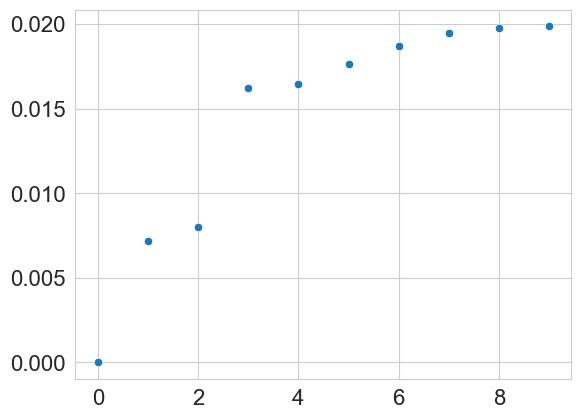

In [45]:

# Step 2: Load the Deezer graph
# Assuming the edge list is in CSV format with two columns: source and target
G = nx.read_edgelist("Data/ca-CondMat.txt/edge_list.txt", nodetype=int)
LCC_nodes = max(nx.connected_components(G), key=len)
G = G.subgraph(LCC_nodes)
laplacian_sparse = nx.normalized_laplacian_matrix(G).astype(np.float64)

degrees = dict(G.degree())
# Compute the square root of the degrees
inv_sqrt_degrees = np.array([1 / np.sqrt(degrees[node]) if degrees[node] != 0 else 0 for node in G.nodes()])

# Step 4: Compute the smallest 6 eigenvalues of the Laplacian (for example)
num_eigenvalues = 10
eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=num_eigenvalues, which="SM")
# Output results
print("\nEigenvalues of the Laplacian:")
print(eigenvalues)
sns.scatterplot(eigenvalues)


In [46]:
K = 3
# Perform K-means clustering on the eigenvectors
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
scaled_eigenvectors = inv_sqrt_degrees[:, np.newaxis] * eigenvectors

clusters = kmeans.fit_predict(scaled_eigenvectors[:, :K])

degrees = dict(G.degree())
# Compute the square root of the degrees
sqrt_degrees = np.array([np.sqrt(degrees[node]) for node in G.nodes()])

# Compute Rayleigh quotients for each cluster
rayleigh_quotients = []
indicator_vectors = np.zeros(eigenvectors.shape)

for cluster_idx in range(K):
    # Create indicator vector for the cluster
    indicator_vector = (clusters == cluster_idx).astype(float) * sqrt_degrees
    indicator_vector = indicator_vector / np.linalg.norm(indicator_vector, 2)
    indicator_vectors[:, cluster_idx] = indicator_vector
    # Compute Rayleigh quotient
    numerator = indicator_vector.T @ laplacian_sparse @ indicator_vector
    denominator = indicator_vector.T @ indicator_vector
    rayleigh_quotients.append(numerator / denominator)

rayleigh_quotients = sorted(rayleigh_quotients)
beta_K_by_K = indicator_vectors.T @ scaled_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
combined_indicator_vectors = gram_schmidt(combined_indicator_vectors)
combined_rayleigh_quotients = []
for i in range(K):
    numerator = combined_indicator_vectors[:, i].T @ laplacian_sparse @ combined_indicator_vectors[:, i]
    denominator = combined_indicator_vectors[:, i].T @ combined_indicator_vectors[:, i]
    combined_rayleigh_quotients.append(numerator / denominator)

combined_rayleigh_quotients = sorted(combined_rayleigh_quotients)

<Axes: >

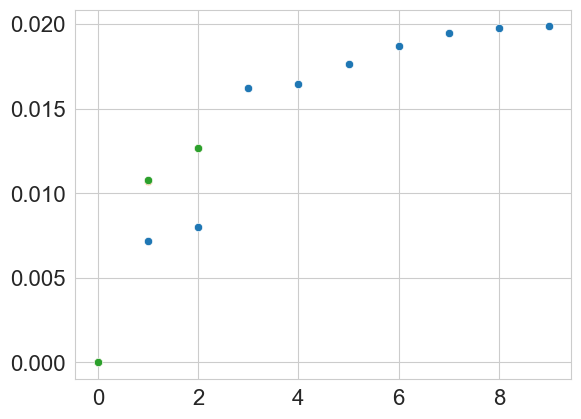

In [47]:
sns.scatterplot(eigenvalues)
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(combined_rayleigh_quotients)

In [48]:
collaborations_dataset_results = {}
true_val_matrix_combined = eigenvectors[:, :K] - indicator_vectors @ (
        indicator_vectors.T @ eigenvectors[:, :K])
true_val_combined = (1 / K) * np.linalg.norm(true_val_matrix_combined)

rayleigh_quotients = np.round(rayleigh_quotients, 6)
normalized_L_eigenvalues = np.round(eigenvalues, 6)

#b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])
split, v = apply_recursive_st_brute_force(rayleigh_quotients, eigenvalues[0:K+1], K)


collaborations_dataset_results = {}
print("K: ", K)
collaborations_dataset_results["K"] = K
print("Number of vertices N: ", len(eigenvectors))
collaborations_dataset_results["N"] = len(eigenvectors)
print("Number of edges M: ", np.sum(list(degrees.values())) / 2)
collaborations_dataset_results["M"] = np.sum(list(degrees.values())) / 2
print("True value: ", true_val_combined)
collaborations_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors))/eigenvalues[K])
collaborations_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors))/eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * eigenvalues[K]))
collaborations_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * eigenvalues[K])
print("Recursive ST: ", v/K)
collaborations_dataset_results["Recursive ST"] = v/K

dataset_results["Collaborations (CA-CondMat)"] = collaborations_dataset_results

K:  3
Number of vertices N:  21363
Number of edges M:  91342.0
True value:  0.06521242630039875
M&S ST:  0.7805900569513127
General ST:  0.4817601480055544
Recursive ST:  0.3370136183078176


In [49]:
pd.DataFrame(dataset_results).T

,K,N,M,True Value,M&S ST,General ST,Recursive ST
MNIST,5.0,2348.0,140018.0,0.050541,0.439451,0.191496,0.174427
Fashion MNIST,6.0,2872.0,1711206.0,0.075998,0.561385,0.376075,0.322478
Wine,3.0,178.0,6890.0,0.064563,0.449814,0.260868,0.224148
Air Quality,3.0,4942.0,2784780.0,0.148915,0.623388,0.288304,0.234962
Twitch,2.0,168114.0,6797557.0,0.078597,0.956694,0.479292,0.393654
LastFM,2.0,7622.0,27800.0,0.048510,0.837269,0.422148,0.312263
Facebook (Athletes),3.0,13866.0,86852.0,0.042710,0.695147,0.403263,0.242659
Collaborations (CA-CondMat),3.0,21363.0,91342.0,0.065212,0.780590,0.481760,0.337014
